In [32]:
# imports

# external modules
import sys
import os
import numpy as np
import pandas as pd
import keras
import matplotlib as mpl
import matplotlib.pyplot as plt
import importlib
# framework modules
sys.path.append('../')
import plotting.plottools
importlib.reload(plotting.plottools)
from plotting.plottools import plot_histogram
import training.prepare_training_set
importlib.reload(training.prepare_training_set)
from training.prepare_training_set import prepare_training_data_from_files
import training.patternfiltering
importlib.reload(training.patternfiltering)
from training.patternfiltering import contains_any_pattern
import datagen.fake_anomaly
importlib.reload(datagen.fake_anomaly)

<module 'datagen.fake_anomaly' from '/eos/home-i00/l/llambrec/pixelae/evaluation/../datagen/fake_anomaly.py'>

In [33]:
# load the evaluation set

#me = 'PixelPhase1-Tracks-PXForward-clusterposition_xy_ontrack_PXDisk_+1'
me = 'PixelPhase1-Tracks-PXForward-clusterposition_xy_ontrack_PXDisk_-2'

files = ([
    '../data/data/ZeroBias-Run2023C-PromptReco-v1-DQMIO-{}_preprocessed.parquet'.format(me)
])
kwargs = ({
    'verbose': True,
    'entries_threshold': 10000,
    'skip_first_lumisections': 5,
    'veto_patterns': [np.zeros((2,2)), np.zeros((2,1)), np.zeros((1,2))]
})
(eval_data, eval_runs, eval_lumis) = prepare_training_data_from_files(files, **kwargs)

Loading file ../data/data/ZeroBias-Run2023C-PromptReco-v1-DQMIO-PixelPhase1-Tracks-PXForward-clusterposition_xy_ontrack_PXDisk_-2_preprocessed.parquet
  Shape of hists array: (18065, 32, 32)
  Runs: [367094 367094 367094 ... 367515 367515 367515]
  Lumis: [  1   2   3 ... 666 667 668]
  Entries: [    0     0     0 ... 61725 59442 20833]
  Passing number of entries: 16502 (91.35 %)
  Passing lumisection skip: 17794 (98.50 %)
  Passing veto patterns: 6733 (37.27 %)
  Training lumisections: 6653 (36.83 %)
Shape of training data: (6653, 32, 32, 1)
Shape of training runs: (6653,)
Shape of training lumis: (6653,)


Text(0.02, 1.02, 'Shape mask')

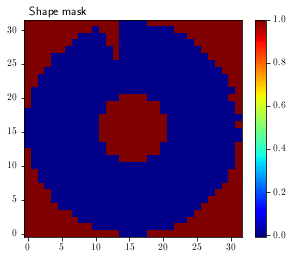

In [34]:
# make a mask where values are often zero

shape_mask = (np.sum(eval_data[:,:,:,0]==0, axis=0)>len(eval_data)*0.5)

# temp: also set edges to zero
#shape_mask[0,:] = 1
#shape_mask[-1,:] = 1
#shape_mask[:,0] = 1
#shape_mask[:,-1] = 1

fig,ax = plt.subplots()
plot_histogram(shape_mask, fig=fig, ax=ax, caxrange=(-0.01,1))
ax.text(0.02, 1.02, 'Shape mask', transform=ax.transAxes, fontsize=12)

In [35]:
# load keras model

modelbase = '../models/output_20231115/model_20231115_Run2023C-v1'
modelname = '{}_{}.keras'.format(modelbase, me)
model = keras.models.load_model(modelname)

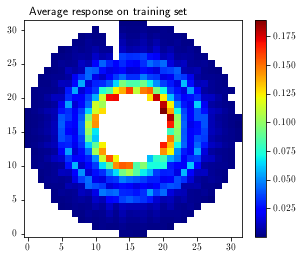

In [36]:
# load average occupancy or error of training set

avgresponsename = '{}_{}_avgoccupancy.npy'.format(modelbase, me)
avgresponse = np.load(avgresponsename)
avgresponse = np.square(avgresponse)

fig,ax = plt.subplots()
plot_histogram(avgresponse, fig=fig, ax=ax)
ax.text(0.02, 1.02, 'Average response on training set', transform=ax.transAxes, fontsize=12)
avgresponse[avgresponse==0] = 1
avgresponse = np.expand_dims(avgresponse, axis=2)

In [37]:
# make a collection of fake anomalies

nanomalies = 6000
random_indices = np.random.choice(len(eval_data), size=nanomalies, replace=True)

anomalies = np.zeros((nanomalies, eval_data.shape[1], eval_data.shape[2], 1))
params = []
for newidx,origidx in enumerate(random_indices):
    hist = eval_data[origidx,:,:,0]
    (anomalous_hist, paramdict) = datagen.fake_anomaly.dead_rectangle(hist, rectangle_min_pixels=2, shape_mask=~shape_mask)
    #(anomalous_hist, paramdict) = datagen.fake_anomaly.dead_sector(hist)
    #(anomalous_hist, paramdict) = datagen.fake_anomaly.hot_rectangle(hist, shape_mask=~shape_mask)
    #(anomalous_hist, paramdict) = datagen.fake_anomaly.hot_sector(hist)
    anomalies[newidx,:,:,0] = anomalous_hist
    params.append(paramdict)

In [38]:
# evaluate the model

predictions = model.predict(eval_data)
predictions[predictions<0] = 0.
predictions[:,shape_mask] = 0.

predictions_anomalies = model.predict(anomalies)
predictions_anomalies[predictions_anomalies<0] = 0.
predictions_anomalies[:,shape_mask] = 0.

188/188 [==============================] - 2s 12ms/step


In [39]:
# calculate squared difference
errors = np.square(eval_data - predictions)
errors[:,shape_mask] = 0.
errors_anomalies = np.square(anomalies - predictions_anomalies)
errors_anomalies[:,shape_mask] = 0.

# space correction
errors_corrected = errors/avgresponse
errors_anomalies_corrected = errors_anomalies/avgresponse

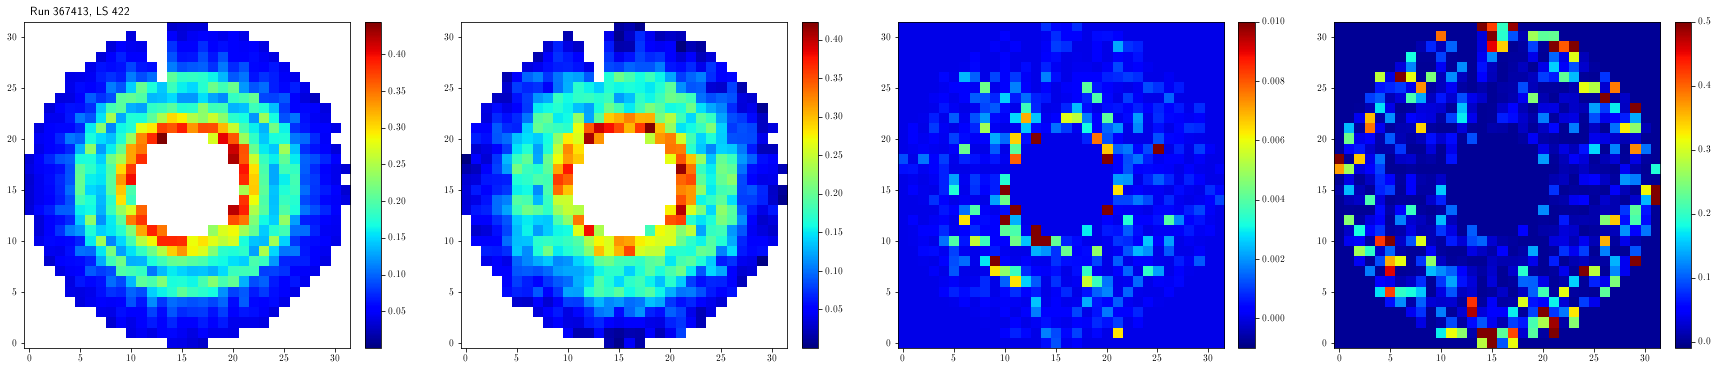

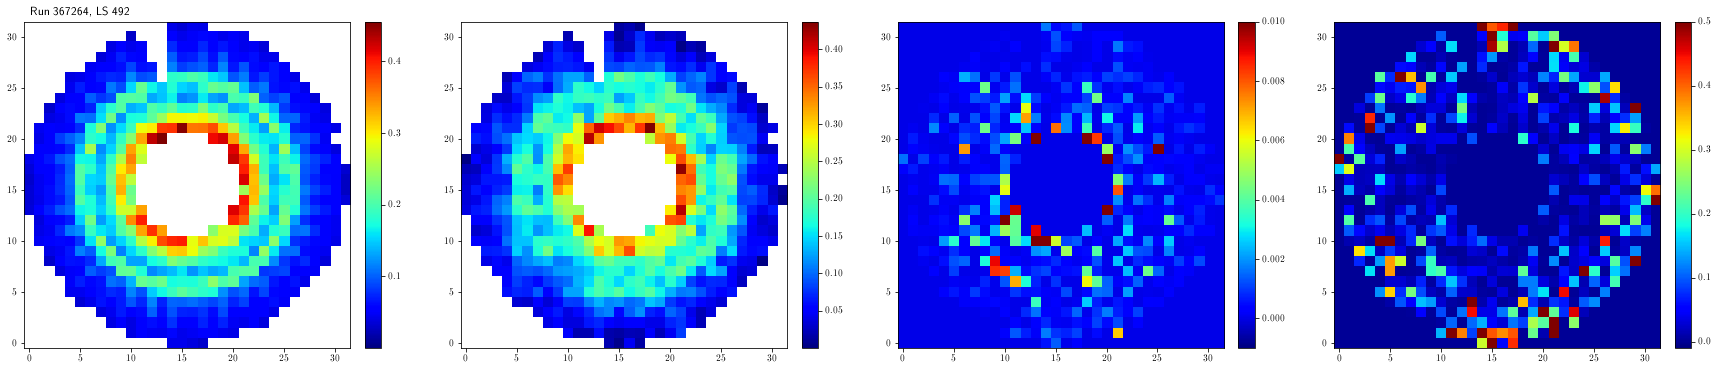

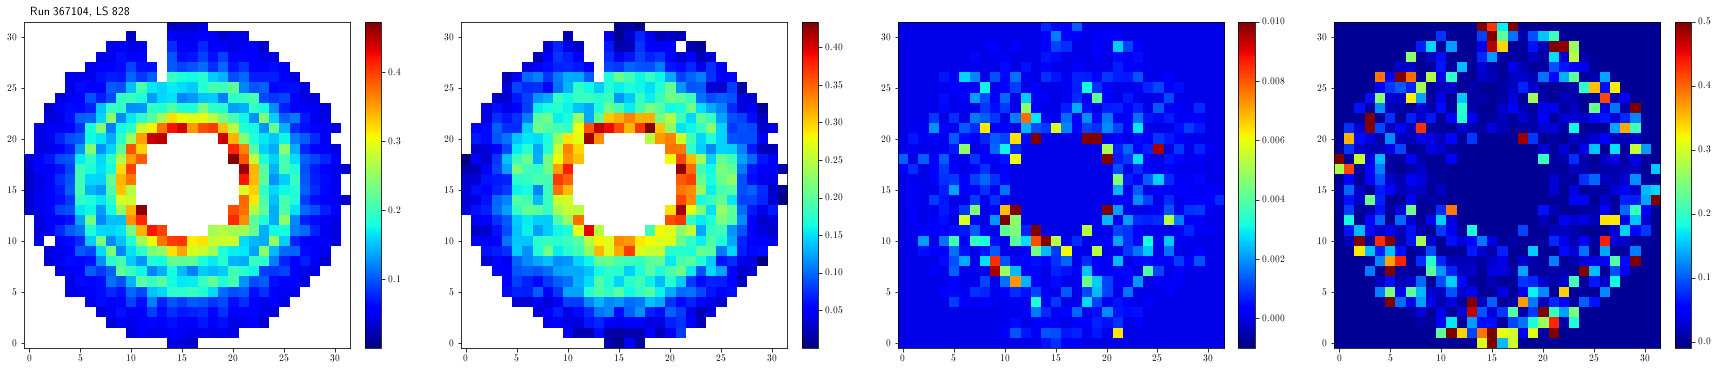

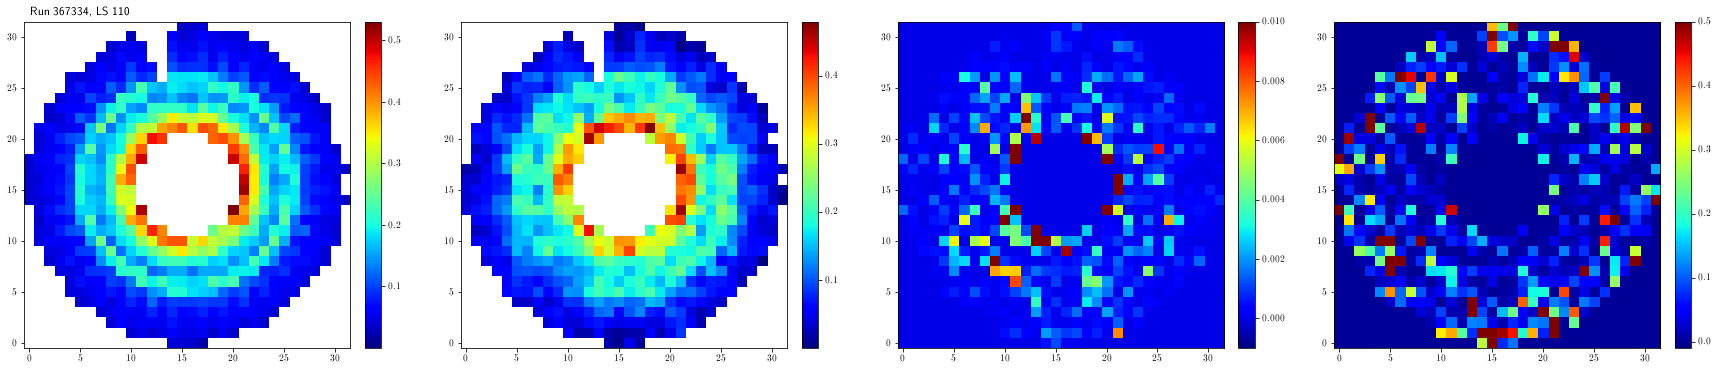

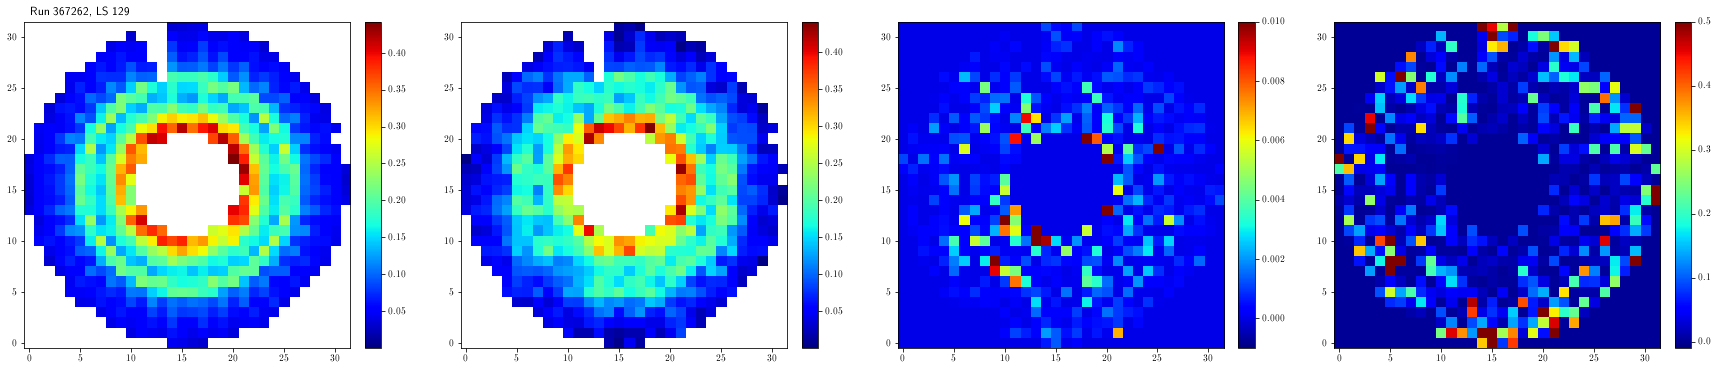

In [40]:
# make plots of evaluation on supposedly non-anomalous histograms

nplots = 5
plotids = np.random.choice(len(eval_data), size=nplots, replace=False)

for i in plotids:
    fig,axs = plt.subplots(figsize=(30,6), ncols=4)
    plot_histogram(eval_data[i,:,:,0], fig=fig, ax=axs[0])
    plot_histogram(predictions[i,:,:,0], fig=fig, ax=axs[1])
    plot_histogram(errors[i,:,:,0], fig=fig, ax=axs[2], caxrange=(-0.001, 0.01))
    plot_histogram(errors_corrected[i,:,:,0], fig=fig, ax=axs[3], caxrange=(-0.01, 0.5))
    axs[0].text(0.02, 1.02, 'Run {}, LS {}'.format(eval_runs[i], eval_lumis[i]), transform=axs[0].transAxes, fontsize=12)

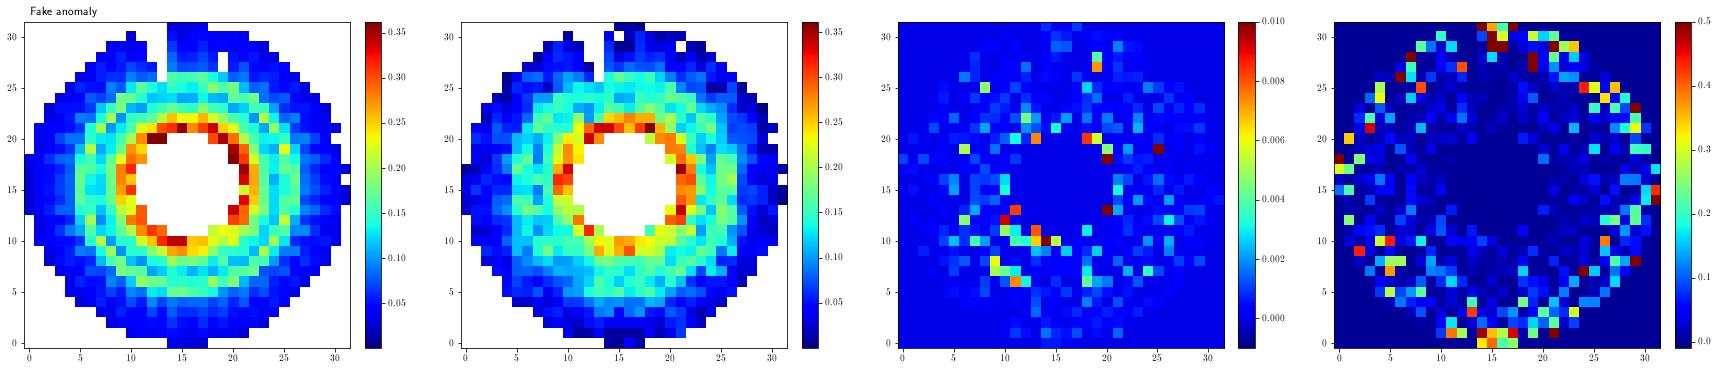

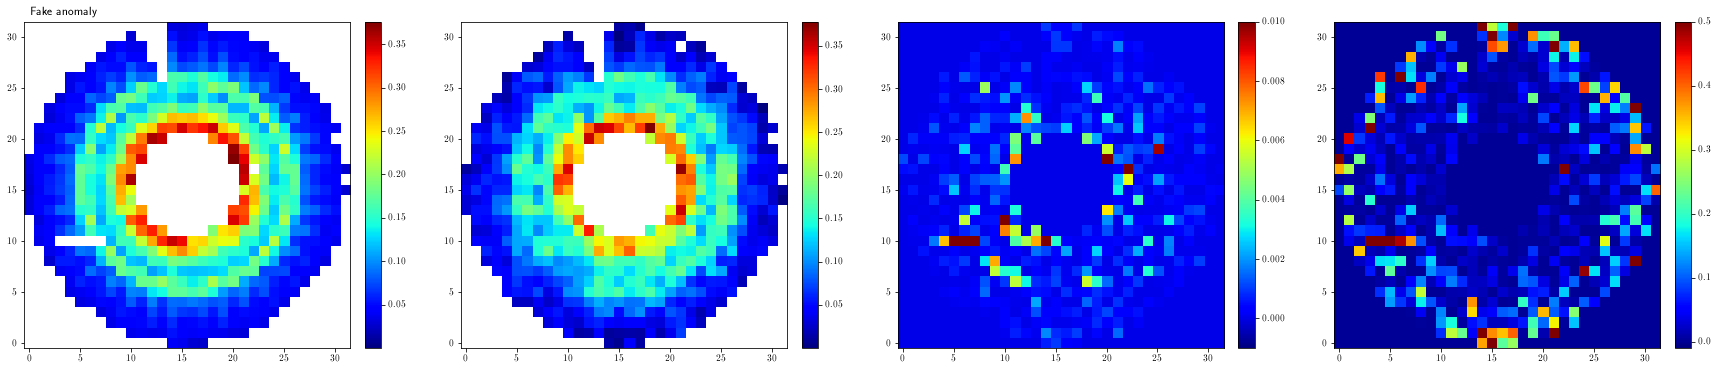

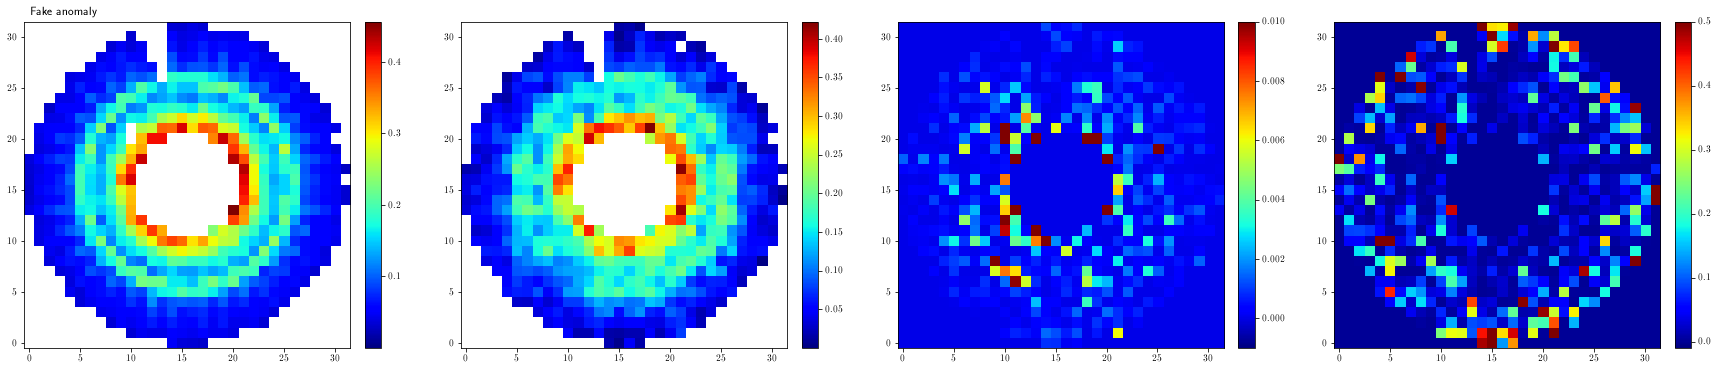

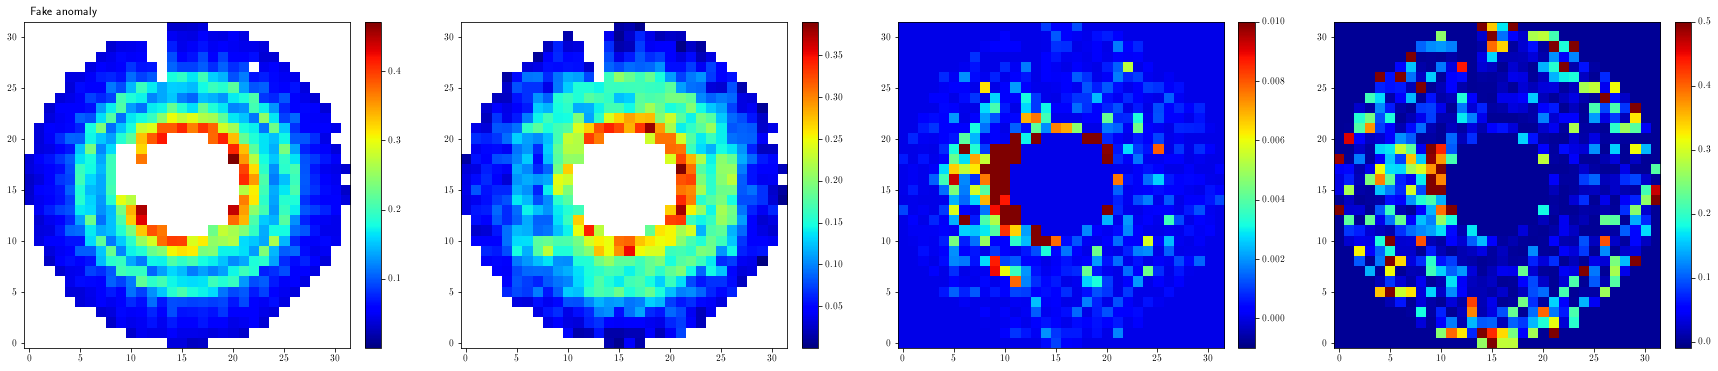

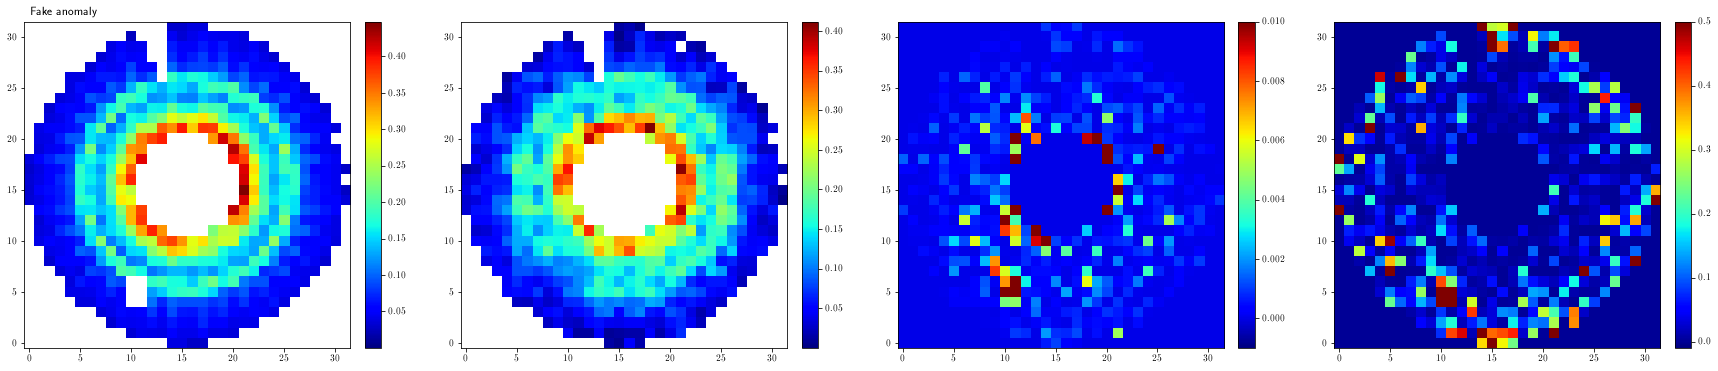

In [41]:
# make plots of evaluation on anomalous histograms

nplots = 5
plotids = np.random.choice(len(anomalies), size=nplots, replace=False)

for i in plotids:
    fig,axs = plt.subplots(figsize=(30,6), ncols=4)
    plot_histogram(anomalies[i,:,:,0], fig=fig, ax=axs[0])
    plot_histogram(predictions_anomalies[i,:,:,0], fig=fig, ax=axs[1])
    plot_histogram(errors_anomalies[i,:,:,0], fig=fig, ax=axs[2], caxrange=(-0.001, 0.01))
    plot_histogram(errors_anomalies_corrected[i,:,:,0], fig=fig, ax=axs[3], caxrange=(-0.01, 0.5))
    axs[0].text(0.02, 1.02, 'Fake anomaly', transform=axs[0].transAxes, fontsize=12)

Threshold: 0.1
6653 out of 6653 non-anomalous histograms were tagged
6000 out of 6000 anomalous histograms were tagged
Threshold: 0.25
6653 out of 6653 non-anomalous histograms were tagged
6000 out of 6000 anomalous histograms were tagged
Threshold: 0.4
6628 out of 6653 non-anomalous histograms were tagged
5996 out of 6000 anomalous histograms were tagged
Threshold: 0.5
5432 out of 6653 non-anomalous histograms were tagged
5898 out of 6000 anomalous histograms were tagged
Threshold: 0.6
2795 out of 6653 non-anomalous histograms were tagged
5484 out of 6000 anomalous histograms were tagged
Threshold: 0.75
787 out of 6653 non-anomalous histograms were tagged
4404 out of 6000 anomalous histograms were tagged
Threshold: 1
124 out of 6653 non-anomalous histograms were tagged
2515 out of 6000 anomalous histograms were tagged


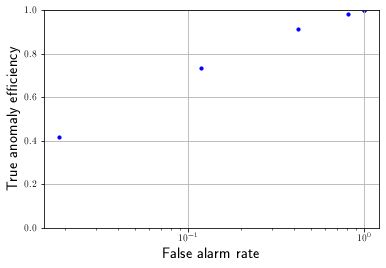

In [42]:
# scan thresholds to make a ROC curve

thresholds = [0.1, 0.25, 0.4, 0.5, 0.6, 0.75, 1]
patterns = [-np.ones((2,2)), -np.ones((2,1)), -np.ones((1,2))]

s_eff = []
b_eff = []
for threshold in thresholds:
    errors_scaled = np.where(errors_corrected>threshold, -1, errors_corrected)
    errors_anomalies_scaled = np.where(errors_anomalies_corrected>threshold, -1, errors_anomalies_corrected)
    flags = contains_any_pattern(errors_scaled[:,:,:,0], patterns)
    flags_anomalies = contains_any_pattern(errors_anomalies_scaled[:,:,:,0], patterns)
    print('Threshold: {}'.format(threshold))
    print('{} out of {} non-anomalous histograms were tagged'.format(sum(flags), len(flags)))
    print('{} out of {} anomalous histograms were tagged'.format(sum(flags_anomalies), len(flags_anomalies)))
    s_eff.append( sum(flags_anomalies)/len(flags_anomalies) )
    b_eff.append( sum(flags)/len(flags) )

fig,ax = plt.subplots()
ax.scatter(b_eff, s_eff, c='b', s=10)
ax.set_xlabel('False alarm rate', fontsize=15)
ax.set_ylabel('True anomaly efficiency', fontsize=15)
ax.grid()
ax.set_ylim((0,1))
ax.set_xscale('log')
plt.show()

Found 787 candidates, of which plotting 5


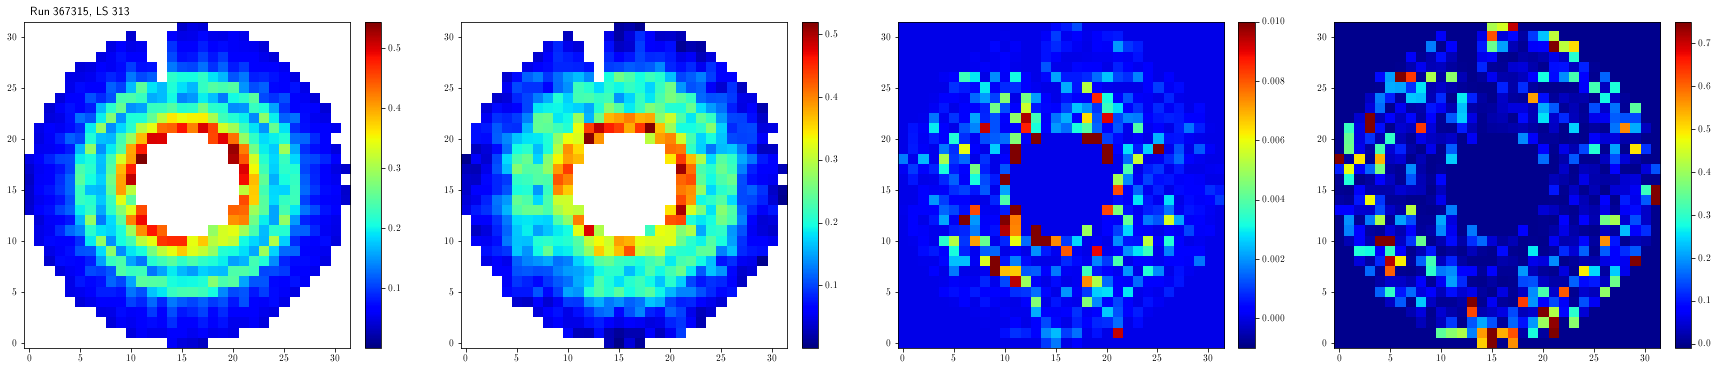

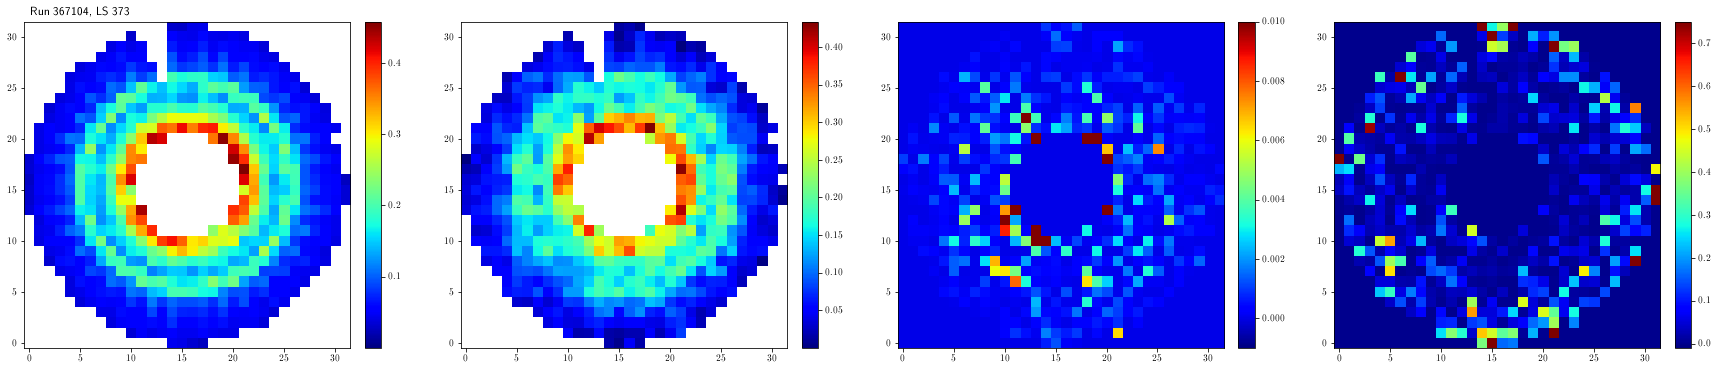

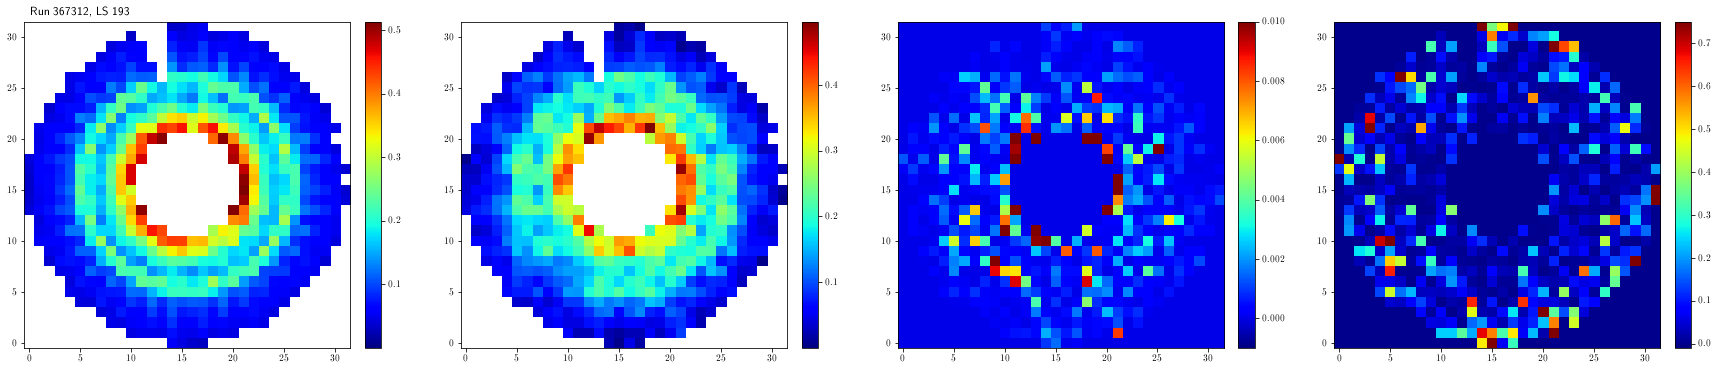

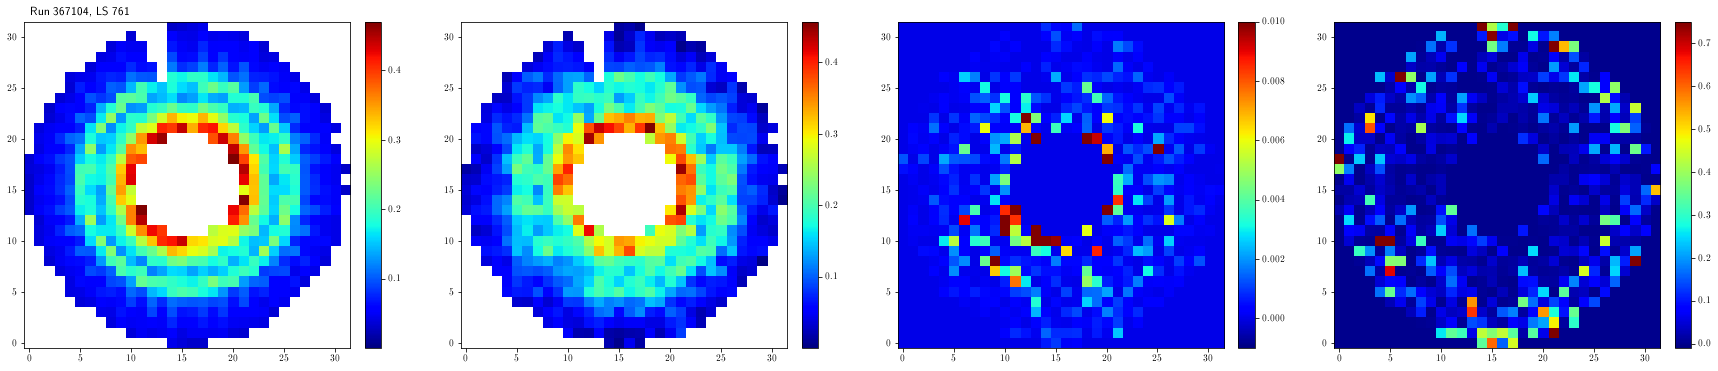

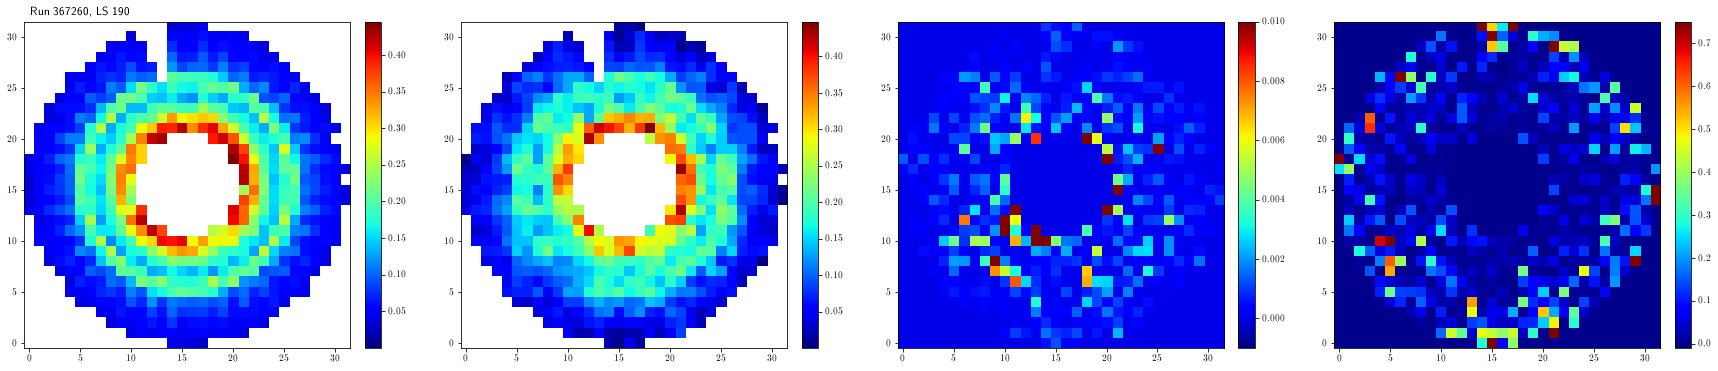

In [43]:
# for a given threshold, investigate mistagged good histograms

nplots = 5
threshold = 0.75
errors_scaled = np.where(errors_corrected>threshold, -1, errors_corrected)
flags = contains_any_pattern(errors_scaled[:,:,:,0], patterns)
print('Found {} candidates, of which plotting {}'.format(sum(flags), nplots))
plotids = np.random.choice(np.arange(len(eval_data))[flags], size=nplots, replace=False)

for i in plotids:
    fig,axs = plt.subplots(figsize=(30,6), ncols=4)
    plot_histogram(eval_data[i,:,:,0], fig=fig, ax=axs[0])
    plot_histogram(predictions[i,:,:,0], fig=fig, ax=axs[1])
    plot_histogram(errors[i,:,:,0], fig=fig, ax=axs[2], caxrange=(-0.001, 0.01))
    plot_histogram(errors_corrected[i,:,:,0], fig=fig, ax=axs[3], caxrange=(-0.01, threshold))
    axs[0].text(0.02, 1.02, 'Run {}, LS {}'.format(eval_runs[i], eval_lumis[i]), transform=axs[0].transAxes, fontsize=12)

Found 1596 candidates, of which plotting 5


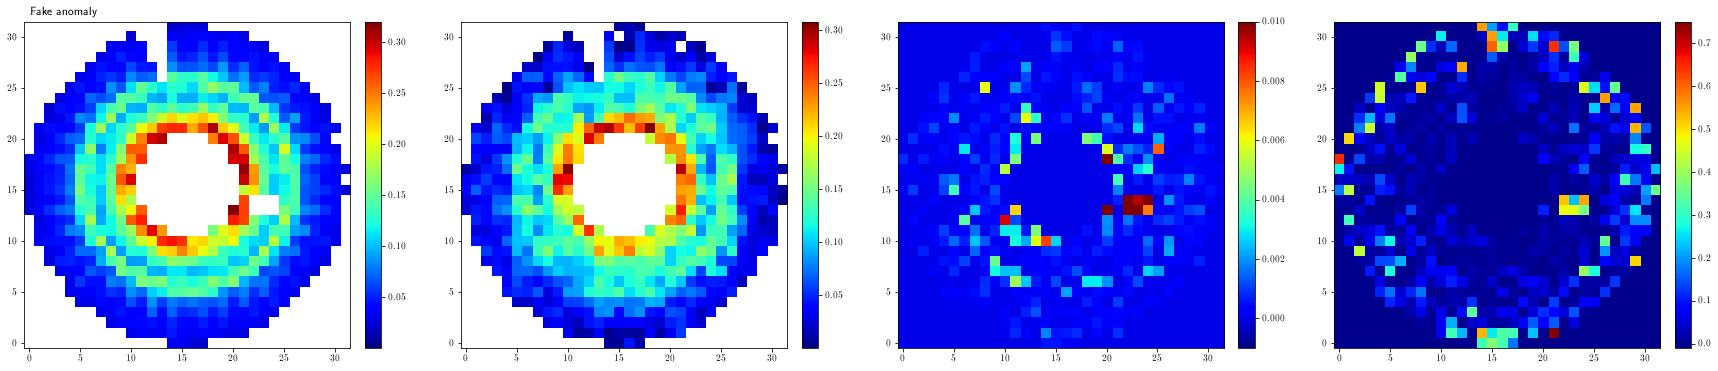

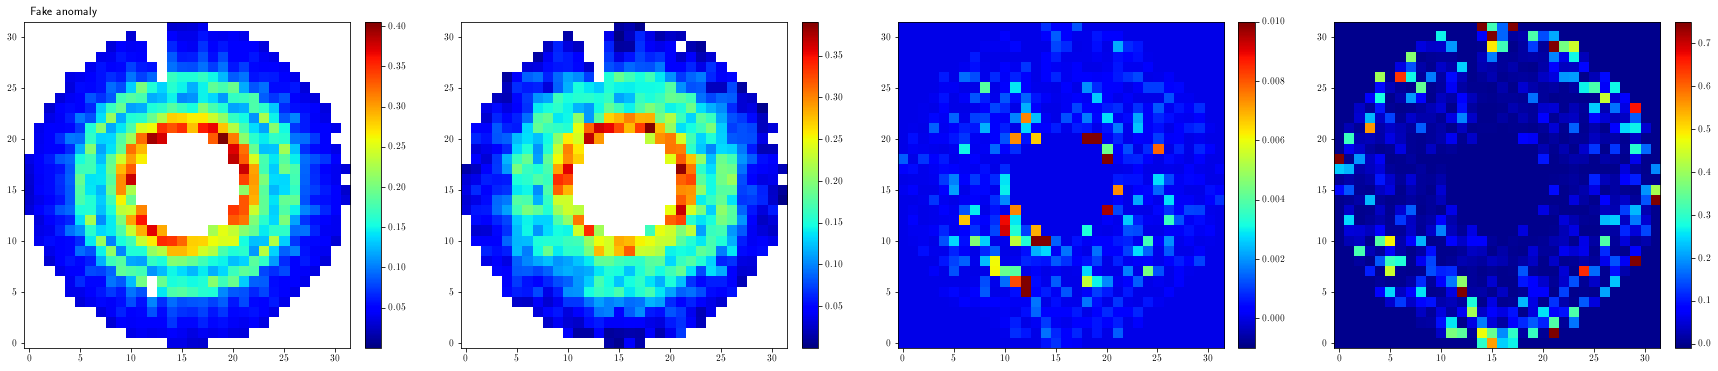

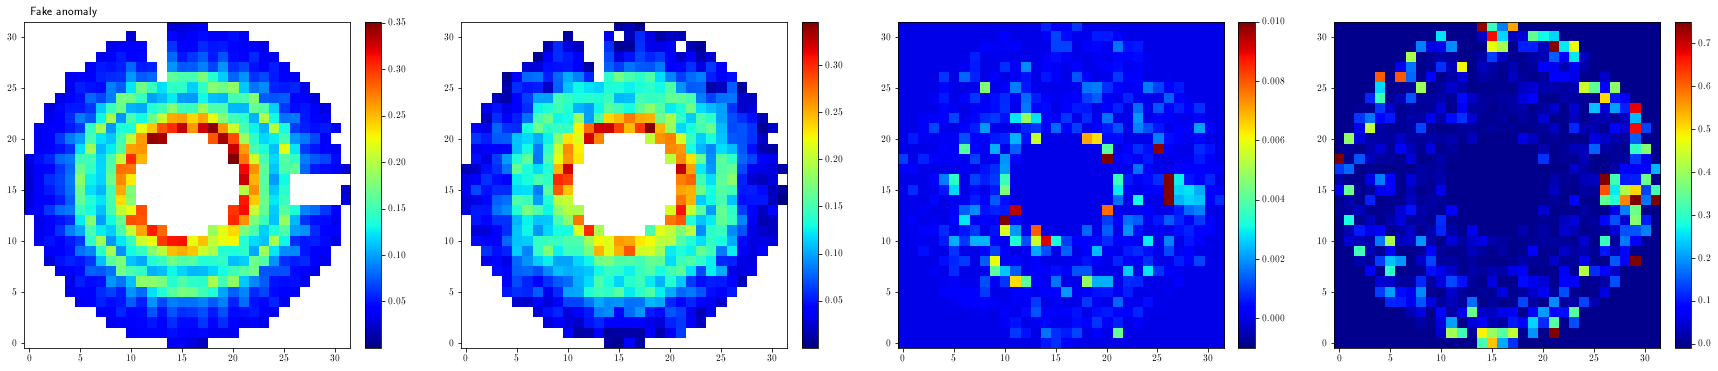

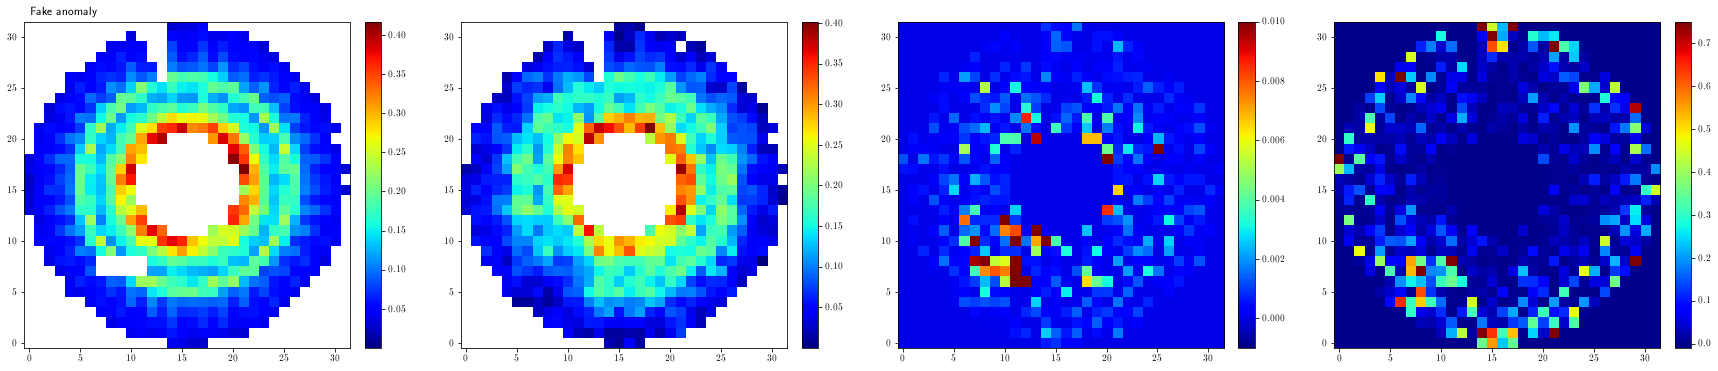

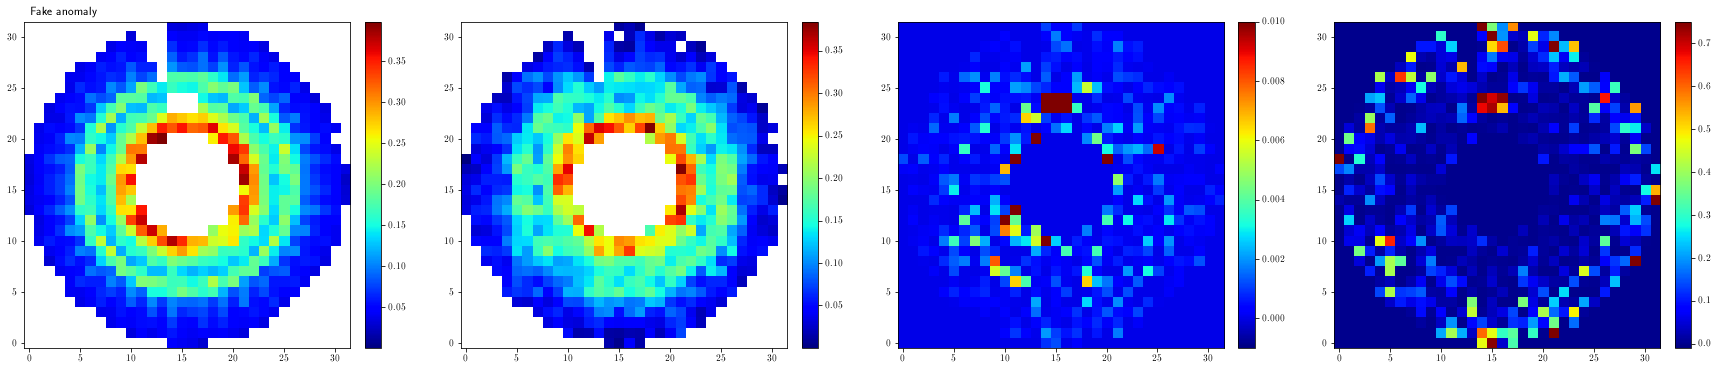

In [44]:
# for a given threshold, investigate missed anomalous histograms

nplots = 5
threshold = 0.75
errors_anomalies_scaled = np.where(errors_anomalies_corrected>threshold, -1, errors_anomalies_corrected)
flags_anomalies = contains_any_pattern(errors_anomalies_scaled[:,:,:,0], patterns)
print('Found {} candidates, of which plotting {}'.format(sum(~flags_anomalies), nplots))
plotids = np.random.choice(np.arange(len(anomalies))[~flags_anomalies], size=nplots, replace=False)

for i in plotids:
    fig,axs = plt.subplots(figsize=(30,6), ncols=4)
    plot_histogram(anomalies[i,:,:,0], fig=fig, ax=axs[0])
    plot_histogram(predictions_anomalies[i,:,:,0], fig=fig, ax=axs[1])
    plot_histogram(errors_anomalies[i,:,:,0], fig=fig, ax=axs[2], caxrange=(-0.001, 0.01))
    plot_histogram(errors_anomalies_corrected[i,:,:,0], fig=fig, ax=axs[3], caxrange=(-0.01, threshold))
    axs[0].text(0.02, 1.02, 'Fake anomaly', transform=axs[0].transAxes, fontsize=12)